Setup an experiment with given data and arch by adjusting config

In [6]:
import os
import utils
import importlib
import pandas as pd
import numpy as np
import datetime as dt
import torch
tnn = torch.nn
top = torch.optim

from torch.utils import data as tdt
%matplotlib inline

ARCHS_DIR = 'archs'
DATA_DIR = 'data'
EXPERIMENTS_DIR = 'experiments'

### Device Info

In [7]:
CUDA="cuda:0"
CPU="cpu"
if torch.cuda.is_available():
    device = torch.device(CUDA)
    cd = torch.cuda.current_device()
    print("Num devices:", torch.cuda.device_count())
    print("Current device:", cd)
    print("Device name:", torch.cuda.get_device_name(cd))
    print("Device props:", torch.cuda.get_device_properties(cd))
#     print(torch.cuda.memory_summary(cd))
else:
    device = torch.device(CPU)
print(device)

cpu


### Experiment Config

In [8]:
config = {
    "ID": "0001_test",
    "DESC": "Check if notebook works.",
    "ARCH": "v1",
    "DATASET": "ds_4020_owid_2020-06-24.csv.pt",
    "BATCH_SIZE": 1000,
    "HIDDEN_SIZE": 20,
    "NUM_LAYERS": 4,
    "LEARNING_RATE": 0.001,
    "NUM_EPOCHS": 10001
}

# checkpoint filename to resume training else ""
RESUME = ""

# setup exp
experiment_dir = EXPERIMENTS_DIR + '/' + config['ID']
try:
    os.mkdir(experiment_dir)
except OSError:
    print("WARNING: Experiment already exists:", config['ID'])
else:
    print("Initialising experiment:", config['ID'])
print("Resume:", RESUME if RESUME else bool(RESUME))

# load data
ds = torch.load(DATA_DIR + "/" + config['DATASET'])
print("Dataset loaded")
config['DS'] = ds['config']
print(config['DS'])

# load arch
arch_mod = importlib.import_module("." + config['ARCH'], ARCHS_DIR)
importlib.reload(arch_mod) # ensure changes are imported

# init Net
model = arch_mod.CovidNet(ip_seq_len=config['DS']['IP_SEQ_LEN'], op_seq_len=config['DS']['OP_SEQ_LEN'], hidden_size=config['HIDDEN_SIZE'], num_layers=config['NUM_LAYERS'])
model = model.to(device)
print ("Model initialised")
print("Num params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# init Loss and Optimizer
loss_fn = tnn.L1Loss()
optimizer = top.Adam(model.parameters(), lr=config['LEARNING_RATE'])

# init dataset loaders
trn_loader = tdt.DataLoader(ds['trn'], shuffle=True, batch_size=config['BATCH_SIZE'])
val_loader = tdt.DataLoader(ds['val'], shuffle=True, batch_size=config['BATCH_SIZE'])

Initialising experiment: 0001_test
Resume: False
Dataset loaded
{'VAL_RATIO': 0.3, 'IP_SEQ_LEN': 40, 'OP_SEQ_LEN': 20, 'SRC': 'owid_2020-06-24.csv'}
Model initialised
Num params: 27940


### Training loop

In [9]:
trn_loss_vals = []
val_loss_vals = []
e = 0
min_val_loss = np.Inf

if RESUME:
#     config, e, md, od, trn_loss_vals, val_loss_vals, min_val_loss = utils.load_checkpoint(experiment_dir, RESUME, device=device)
    e+=1
    model.load_state_dict(md)
    optimizer.load_state_dict(od)

# TRAIN
print("BEGIN: [", dt.datetime.now(), "]")
while e < config['NUM_EPOCHS']:
    model.train()
    trn_losses = []
    for data in trn_loader:
        ip, op = data
        ip = ip.to(device)
        op = op.to(device)
        optimizer.zero_grad() # set grads to 0
        preds = model(ip.view(-1, config['DS']['IP_SEQ_LEN'], 1)) # predict
        loss = loss_fn(preds, op.view(-1, config['DS']['OP_SEQ_LEN'])) # calc loss
        loss.backward() # calc and assign grads
        optimizer.step() # update weights
        trn_losses.append(loss) # logging
    avg_trn_loss = torch.stack(trn_losses).mean().item() * 10000
    trn_loss_vals.append(avg_trn_loss)
    
    model.eval()
    with torch.no_grad():
        val_losses = []
        for data in val_loader:
            ip, op = data
            ip = ip.to(device)
            op = op.to(device)
            preds = model(ip.view(-1, config['DS']['IP_SEQ_LEN'], 1))
            loss = loss_fn(preds, op.view(-1, config['DS']['OP_SEQ_LEN']))
            val_losses.append(loss)
        avg_val_loss = torch.stack(val_losses).mean().item() * 10000
        val_loss_vals.append(avg_val_loss)
    
    if e%10==0:
        print("[", dt.datetime.now(), "] epoch:", f"{e:3}", "val_loss:", f"{avg_val_loss: .5f}", "trn_loss:", f"{avg_trn_loss: .5f}")
        if e%100==0:
            utils.save_checkpoint(config, e, model, optimizer, trn_loss_vals, val_loss_vals, min_val_loss, experiment_dir, "/latest-e" + str(e) + ".pt")
        if avg_val_loss <= min_val_loss:
            min_val_loss = avg_val_loss
            utils.save_checkpoint(config, e, model, optimizer, trn_loss_vals, val_loss_vals, min_val_loss, experiment_dir, "/best-e" + str(e) + ".pt")
    e+=1
print("END: [", dt.datetime.now(), "]")

BEGIN: [ 2020-06-24 21:29:56.753824 ]
[ 2020-06-24 21:30:01.152979 ] epoch:   0 val_loss:  272.57094 trn_loss:  1684.19480
Checkpoint saved
Checkpoint saved
[ 2020-06-24 21:30:04.357433 ] epoch:   1 val_loss:  275.22618 trn_loss:  273.77203
Checkpoint saved
[ 2020-06-24 21:30:08.801024 ] epoch:   2 val_loss:  270.91347 trn_loss:  280.46126
Checkpoint saved
Checkpoint saved
[ 2020-06-24 21:30:13.667845 ] epoch:   3 val_loss:  274.97433 trn_loss:  275.15506
Checkpoint saved
[ 2020-06-24 21:30:18.159928 ] epoch:   4 val_loss:  266.19911 trn_loss:  263.67273
Checkpoint saved
Checkpoint saved
[ 2020-06-24 21:30:21.786451 ] epoch:   5 val_loss:  281.31630 trn_loss:  257.21256
Checkpoint saved
[ 2020-06-24 21:30:26.547042 ] epoch:   6 val_loss:  259.10402 trn_loss:  259.38641
Checkpoint saved
Checkpoint saved
[ 2020-06-24 21:30:31.093434 ] epoch:   7 val_loss:  270.80996 trn_loss:  261.62671
Checkpoint saved
[ 2020-06-24 21:30:35.740956 ] epoch:   8 val_loss:  264.67668 trn_loss:  259.11281
C

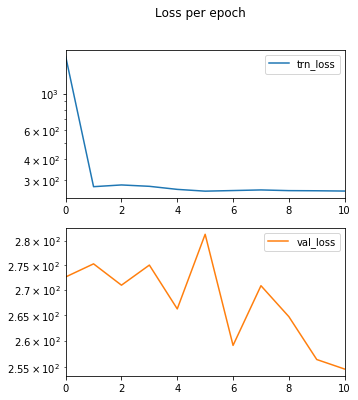

In [10]:
df_loss = pd.DataFrame({
    'trn_loss': trn_loss_vals,
    'val_loss': val_loss_vals
})

# smoothen
df_loss['trn_loss'] = df_loss['trn_loss'].rolling(1, min_periods=1, center=True).mean()
df_loss['val_loss'] = df_loss['val_loss'].rolling(1, min_periods=1, center=True).mean()

_ = df_loss.plot(
    y=['trn_loss', 'val_loss'],
    title='Loss per epoch',
    subplots=True,
    figsize=(5,6),
    sharex=False,
    logy=True
)